In [ ]:
!pip install networkx 
!pip install retworkx
!pip install Qiskit
!pip install qiskit_nature
!pip install qiskit_ignis
!pip install qiskit-ibm-runtime
!pip install mthree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

from time import time

import matplotlib.pyplot as plt

import networkx as nx

from qiskit.primitives import Estimator

from qiskit import IBMQ
#from qiskit.providers.aer import QasmSimulator, Aer

from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute

from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector

from qiskit.opflow import X, Z, I,Y

from qiskit.result import marginal_counts

import mthree
import util
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler)
from qiskit.primitives import Sampler

import itselfmiti1

from qiskit.providers.aer import QasmSimulator, Aer

from qiskit.utils.mitigation.fitters import CompleteMeasFitter,TensoredFilter,TensoredMeasFitter

from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal

import copy

In [ ]:

#provider = IBMQ.enable_account('c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51')
IBMQ.update_account()
print(IBMQ.providers())


provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_belem'))
backend_real_jakarta = provider.get_backend('ibmq_belem')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_real_jakarta


Found 0 credentials.
No credentials available for updating could be found. No action will be performed.
[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>]


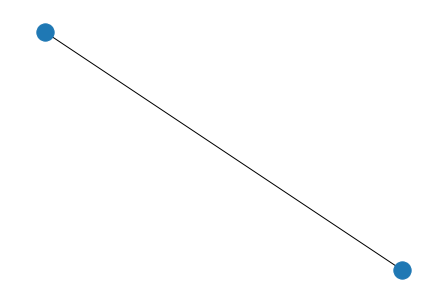

In [ ]:

g = nx.Graph()
 
g.add_edge(0, 1)

nx.draw(g)
plt.show()


In [ ]:
g=1
h=1

In [ ]:
def trotter_step_OBC(dt):

  qr=QuantumRegister(2)
  circuit = QuantumCircuit(qr)

  for i in range (0,2):
    circuit.rx(g*dt, qr[i])
  
  circuit.cx(qr[1],qr[0])
  circuit.rz(h*dt,qr[0])
  circuit.cx(qr[1],qr[0])

  return circuit

In [ ]:
trotter_step_OBC(0.01).draw()

┌──────────┐┌───┐┌──────────┐┌───┐
q210247_0: ┤ Rx(0.01) ├┤ X ├┤ Rz(0.01) ├┤ X ├
           ├──────────┤└─┬─┘└──────────┘└─┬─┘
q210247_1: ┤ Rx(0.01) ├──■────────────────■──
           └──────────┘

In [ ]:
def N_circ_OBC(N,t):
  qr=QuantumRegister(2)
  circuit = QuantumCircuit(qr) 

  dt=t/N
  for _ in range (0,N):
    circuit.append(trotter_step_OBC(dt),qr)
  return circuit


In [ ]:
N_circ_OBC(10,0.01).draw()

┌─────────────────┐┌─────────────────┐┌─────────────────┐»
q210248_0: ┤0                ├┤0                ├┤0                ├»
           │  circuit-485867 ││  circuit-485870 ││  circuit-485873 │»
q210248_1: ┤1                ├┤1                ├┤1                ├»
           └─────────────────┘└─────────────────┘└─────────────────┘»
«           ┌─────────────────┐┌─────────────────┐┌─────────────────┐»
«q210248_0: ┤0                ├┤0                ├┤0                ├»
«           │  circuit-485876 ││  circuit-485879 ││  circuit-485882 │»
«q210248_1: ┤1                ├┤1                ├┤1                ├»
«           └─────────────────┘└─────────────────┘└─────────────────┘»
«           ┌─────────────────┐┌─────────────────┐┌─────────────────┐»
«q210248_0: ┤0                ├┤0                ├┤0                ├»
«           │  circuit-485885 ││  circuit-485888 ││  circuit-485891 │»
«q210248_1: ┤1                ├┤1                ├┤1                ├»
«           └─────────────────┘└─────────────────┘└─────────────────┘»
«           ┌─────────────────┐
«q210248_0: ┤0                ├
«           │  circuit-485894 │
«q210248_1: ┤1                ├
«           └─────────────────┘

In [ ]:
def circs_run(num_trots,num_times,time,backend,qubits=[0,1,2,3,4,5,6],qubits_measure=[0],shots=30000):
    circs=[]
    times=time*np.arange(1,num_times+1,1,dtype=float)/(num_times+1)
    print(times)
    config=backend.configuration()
    N_qubits_backend=config.n_qubits
    N_qubits_measure=len(qubits_measure)

    for i in range (0,num_trots):
      for k in range (0,num_times):
        qr=QuantumRegister(N_qubits_backend,name="q")
        cr=ClassicalRegister(len(qubits_measure))
        qc=QuantumCircuit(qr,cr)
        qr_target=[]
        for qubit in qubits:
            qr_target.append(qr[qubit])
        qc.append(N_circ_OBC(i+2,times[k]),qr_target)
        for j,qubit in enumerate(qubits_measure):
          qc.measure(qr[qubit],cr[j])
        qc=transpile(qc,backend=BACKEND,optimization_level=0)
        circs.append(qc)
        if (k==0):
          calci=copy.deepcopy(qc)
          calci.remove_final_measurements()
      calci.draw()
      cal_circs_GEM, s_labels = itselfmiti1.GEM_calibration_circuits(calci,qubits_measure=qubits_measure)
      circs.append(cal_circs_GEM[0][0])
      circs.append(cal_circs_GEM[0][1])
      circs.append(cal_circs_GEM[1][0])
      circs.append(cal_circs_GEM[1][1])
    return circs,s_labels

In [ ]:
qr = QuantumRegister(5)
mit_pattern = [[0]]
shots=100000
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
print(len(meas_calibs))
job_cal = execute(meas_calibs, backend=backend_sim_noisy_jakarta, shots=shots)
cal_results = job_cal.result()
cal_counts=cal_results.get_counts()
print(cal_counts)
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)


2
[{'1': 365, '0': 99635}, {'0': 4065, '1': 95935}]


[0.48332195 0.96664389 1.44996584 1.93328779 2.41660973 2.89993168
 3.38325363 3.86657557 4.34989752 4.83321947 5.31654141 5.79986336]


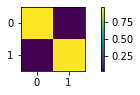

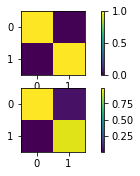

{'0': 9200.429877194318, '1': 799.5701228056813}
new_counts
{'0': 9404.330704688056, '1': 595.6692953119408}
{'0': 7802.256851173381, '1': 2197.7431488266197}
new_counts
{'0': 7937.981122967502, '1': 2062.0188770324976}
{'0': 6031.166039927824, '1': 3968.833960072175}
new_counts
{'0': 6080.529847677236, '1': 3919.470152322763}
{'0': 4635.142434175774, '1': 5364.857565824226}
new_counts
{'0': 4616.4344944774475, '1': 5383.5655055225525}
{'0': 4212.78878061656, '1': 5787.21121938344}
new_counts
{'0': 4173.486381683983, '1': 5826.513618316017}
{'0': 4522.299833111459, '1': 5477.700166888542}
new_counts
{'0': 4498.089555910137, '1': 5501.910444089864}
{'0': 5865.663401497185, '1': 4134.336598502816}
new_counts
{'0': 5906.957106593056, '1': 4093.042893406944}
{'0': 7331.542181438452, '1': 2668.4578185615487}
new_counts
{'0': 7444.313854160382, '1': 2555.6861458396174}
{'0': 8447.071467250624, '1': 1552.9285327493758}
new_counts
{'0': 8614.23765558209, '1': 1385.762344417908}
{'0': 9306.8242

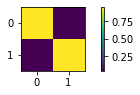

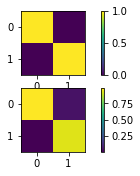

{'0': 9072.541464355138, '1': 927.4585356448624}
new_counts
{'0': 9421.828363938657, '1': 578.1716360613434}
{'0': 7658.248253840654, '1': 2341.751746159346}
new_counts
{'0': 7886.260433437171, '1': 2113.7395665628296}
{'0': 6145.083290501662, '1': 3854.9167094983377}
new_counts
{'0': 6243.342561819475, '1': 3756.6574381805253}
{'0': 4799.5701234579865, '1': 5200.4298765420135}
new_counts
{'0': 4782.45251863801, '1': 5217.547481361992}
{'0': 4352.49865283233, '1': 5647.50134716767}
new_counts
{'0': 4297.044961116637, '1': 5702.955038883364}
{'0': 4630.843559580568, '1': 5369.156440419432}
new_counts
{'0': 4599.257762000788, '1': 5400.742237999213}
{'0': 5082.2137341501475, '1': 4917.786265849853}
new_counts
{'0': 5089.332634524407, '1': 4910.667365475596}
{'0': 5652.874798484014, '1': 4347.125201515986}
new_counts
{'0': 5708.927512773281, '1': 4291.07248722672}
{'0': 5386.351423963793, '1': 4613.648576036207}
new_counts
{'0': 5419.549932792247, '1': 4580.450067207754}
{'0': 4804.943647

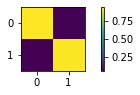

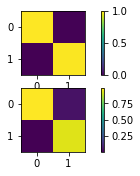

{'0': 8971.520687701593, '1': 1028.4793122984067}
new_counts
{'0': 9510.281637942315, '1': 489.7183620576865}
{'0': 7662.547017251739, '1': 2337.452982748262}
new_counts
{'0': 8022.8079096724805, '1': 1977.192090327521}
{'0': 6026.867279001611, '1': 3973.1327209983897}
new_counts
{'0': 6164.076375619404, '1': 3835.9236243805967}
{'0': 4946.802898050124, '1': 5053.197101949875}
new_counts
{'0': 4936.727477949652, '1': 5063.272522050347}
{'0': 4480.386878698632, '1': 5519.613121301368}
new_counts
{'0': 4406.707974202792, '1': 5593.292025797208}
{'0': 4724.341751957055, '1': 5275.658248042945}
new_counts
{'0': 4683.930101008896, '1': 5316.069898991105}
{'0': 4894.143102134087, '1': 5105.856897865913}
new_counts
{'0': 4876.8866540053195, '1': 5123.1133459946805}
{'0': 4976.893976004611, '1': 5023.106023995388}
new_counts
{'0': 4970.92196858233, '1': 5029.078031417669}
{'0': 4246.104248138899, '1': 5753.895751861101}
new_counts
{'0': 4140.477059238868, '1': 5859.522940761133}
{'0': 3304.675

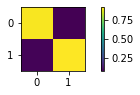

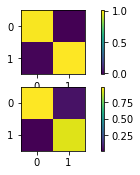

{'0': 8823.213326168268, '1': 1176.7866738317325}
new_counts
{'0': 9579.813382771154, '1': 420.18661722884764}
{'0': 7569.048899208037, '1': 2430.951100791962}
new_counts
{'0': 8080.248105259505, '1': 1919.7518947404944}
{'0': 6161.203654947522, '1': 3838.796345052476}
new_counts
{'0': 6396.931469082964, '1': 3603.0685309170344}
{'0': 5168.188683644447, '1': 4831.811316355554}
new_counts
{'0': 5209.614448280128, '1': 4790.385551719874}
{'0': 4572.810306801495, '1': 5427.189693198506}
new_counts
{'0': 4497.739097885385, '1': 5502.260902114616}
{'0': 4727.565823331645, '1': 5272.434176668355}
new_counts
{'0': 4682.775440890633, '1': 5317.224559109368}
{'0': 4999.462266966135, '1': 5000.537733033865}
new_counts
{'0': 5007.873535836131, '1': 4992.126464163869}
{'0': 4838.259000394108, '1': 5161.740999605892}
new_counts
{'0': 4815.127819264685, '1': 5184.872180735315}
{'0': 3963.4605050991627, '1': 6036.539494900838}
new_counts
{'0': 3769.158550671059, '1': 6230.841449328942}
{'0': 2777.001

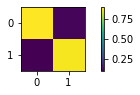

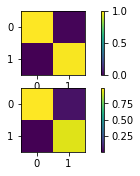

{'0': 8638.366469659857, '1': 1361.6335303401418}
new_counts
{'0': 9527.361843172977, '1': 472.63815682702165}
{'0': 7468.027942735311, '1': 2531.97205726469}
new_counts
{'0': 8067.211623076649, '1': 1932.7883769233524}
{'0': 6137.560451600129, '1': 3862.439548399871}
new_counts
{'0': 6407.279598863887, '1': 3592.720401136114}
{'0': 4879.097235249426, '1': 5120.902764750574}
new_counts
{'0': 4837.1823149896445, '1': 5162.817685010356}
{'0': 4761.956104690853, '1': 5238.043895309149}
new_counts
{'0': 4691.033449825897, '1': 5308.966550174106}
{'0': 5070.392086241789, '1': 4929.607913758212}
new_counts
{'0': 5075.847634770064, '1': 4924.152365229937}
{'0': 4881.246670017217, '1': 5118.753329982784}
new_counts
{'0': 4839.86401569168, '1': 5160.135984308321}
{'0': 4516.926383743169, '1': 5483.073616256832}
new_counts
{'0': 4385.326859176363, '1': 5614.67314082364}
{'0': 3631.3809779715434, '1': 6368.619022028457}
new_counts
{'0': 3280.4932666767663, '1': 6719.506733323235}
{'0': 2369.69371

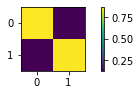

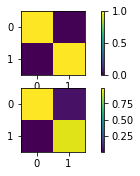

{'0': 8378.291241279703, '1': 1621.708758720296}
new_counts
{'0': 9519.182938904607, '1': 480.8170610953934}
{'0': 7532.509403552015, '1': 2467.490596447985}
new_counts
{'0': 8386.239746383639, '1': 1613.7602536163604}
{'0': 6128.962923326612, '1': 3871.037076673388}
new_counts
{'0': 6506.158667283781, '1': 3493.841332716219}
{'0': 5092.960774654154, '1': 4907.039225345847}
new_counts
{'0': 5118.411225308733, '1': 4881.588774691269}
{'0': 4743.686190664246, '1': 5256.313809335754}
new_counts
{'0': 4650.5503129544495, '1': 5349.4496870455505}
{'0': 4831.8108868891195, '1': 5168.189113110879}
new_counts
{'0': 4768.59526287816, '1': 5231.404737121838}
{'0': 4706.072004195578, '1': 5293.927995804421}
new_counts
{'0': 4600.165290953526, '1': 5399.834709046473}
{'0': 4453.5196082806315, '1': 5546.480391719369}
new_counts
{'0': 4261.865856107041, '1': 5738.13414389296}
{'0': 3335.840944954799, '1': 6664.159055045201}
new_counts
{'0': 2764.710943862841, '1': 7235.28905613716}
{'0': 2394.411606

In [ ]:
circuits=[]
num_trots=6
num_times=12
time=2*np.pi
times=time*np.arange(1,num_times+1,1,dtype=float)/(num_times+1)
shots=10000
config=BACKEND.configuration()
initial_layout=[1,3]
N_qubits_backend=config.n_qubits


circ_meas,s_labels=itselfmiti1.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=[initial_layout[0]])
circs,s_labels=circs_run(num_trots,num_times,time,backend=BACKEND,qubits=initial_layout,qubits_measure=[initial_layout[0]])
circuits+=circ_meas
circuits+=circs

job=execute(circuits,BACKEND,shots=shots,optimization_level=0)
job_result=job.result()
job_counts=job_result.get_counts()



In [ ]:
job = provider.get_backend('ibmq_belem').retrieve_job('63f34dc45b88709e3d1dfe72')

job_result=job.result()
job_counts=job_result.get_counts()

In [ ]:
P_t=[]
G=[]

Probs_GEM=[]
Probs_GEM_P=[]
Probs_raw=[]
Probs_meas=[]
C_GEM_plus=[]
C_GEM=[]
job_qiskit=copy.deepcopy(cal_results)
job_qiskit.results[0].data.counts=job_counts[0]
job_qiskit.results[1].data.counts=job_counts[1]
meas_fitter = CompleteMeasFitter(job_qiskit, state_labels=s_labels)
for trot in range(0,num_trots):
    job_GEM_L=copy.deepcopy(cal_results)
    job_GEM_L.results[0].data.counts=meas_fitter.filter.apply(job_counts[trot*(num_times+4)+num_times+2],method="least_squares")
    job_GEM_L.results[1].data.counts=meas_fitter.filter.apply(job_counts[trot*(num_times+4)+num_times+1+2],method="least_squares")
    job_GEM_R=copy.deepcopy(cal_results)
    job_GEM_R.results[0].data.counts=meas_fitter.filter.apply(job_counts[trot*(num_times+4)+num_times+2+2],method="least_squares")
    job_GEM_R.results[1].data.counts=meas_fitter.filter.apply(job_counts[trot*(num_times+4)+num_times+3+2],method="least_squares")
    
    
    meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
    meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
    Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
    Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
    C=(Cal_GEM_L+Cal_GEM_R)/2
    
    C_GEM.append(C)

    a=np.sum(C,axis=1,dtype='float')
    a=a/(a[0]+a[1])
    
    p_t=(C[0][0]-1)/(a[0]-1)
    P_t.append(p_t)

    b=dict([('0',p_t*a[0]*shots),('1',p_t*a[1]*shots)])

    G.append(b)
    B=np.zeros((2,2))
    for i in range (0,2):
        for j in range (0,2):
            B[i][j]=(C[i][j]-p_t*a[j])/(1-p_t)
    C_GEM_plus.append(B)

    
    meas_fitter_GEM_plus=copy.deepcopy(meas_fitter)
    meas_fitter_GEM_plus.cal_matrices=C_GEM_plus

    meas_fitter_GEM=copy.deepcopy(meas_fitter)
    meas_fitter_GEM.cal_matrices=C_GEM
    P_GEM=[]
    P_GEM_plus=[]
    P_raw=[]
    P_meas=[]
    for t in range (0,num_times):
      raw_counts=job_counts[trot*(num_times+4)+t+2]
      meas_counts=meas_fitter.filter.apply(job_counts[trot*(num_times+4)+t+2],method="least_squares")
      if '1' not in meas_counts.keys():
        meas_counts['1']=0
      if '0' not in meas_counts.keys():
        meas_counts['0']=0
      #meas_vect=util.occurences_to_vector(meas_counts)
      c=dict([('0',(meas_counts['0']-b['0'])/(1-p_t)),('1',(meas_counts['1']-b['1'])/(1-p_t))])
      
      new_counts_GEM_plus=meas_fitter_GEM_plus.filter.apply(c,method="least_squares")
      new_counts_GEM=meas_fitter_GEM.filter.apply(meas_counts,method="least_squares")
      for output in ['0']:
          if output in new_counts_GEM:
              p_GEM = new_counts_GEM[output]/shots
          else:
              p_GEM= 0
      for output in ['0']:
          if output in new_counts_GEM_plus:
              p_GEM_plus= new_counts_GEM_plus[output]/shots
          else:
              p_GEM_plus= 0
      for output in ['0']:
          if output in meas_counts:
              p_meas = meas_counts[output]/shots
          else:
              p_meas = 0
      for output in ['0']:
          if output in raw_counts:
              p_raw = raw_counts[output]/shots
          else:
              p_raw = 0        
      P_GEM_plus.append(p_GEM_plus)
      P_GEM.append(p_GEM)
      P_raw.append(p_raw)
      P_meas.append(p_meas)
    Probs_GEM.append(P_GEM)
    Probs_GEM_P.append(P_GEM_plus)
    Probs_raw.append(P_raw)
    Probs_meas.append(P_meas)

In [ ]:
    for i in range (0,num_trots)
      plt.subplot(311)
      plt.imshow(C_GEM[i])
      plt.colorbar()
      plt.show()
      plt.subplot(312)
      plt.imshow(C_GEM_plus[i])
      plt.colorbar()
      plt.subplot(313)
      plt.imshow(C_qiskit[i])
      plt.colorbar()
      plt.show()

In [ ]:
print(P_t)

[0.04649406700114628, 0.07897711171097249, 0.12000215830877424, 0.16364799467658492, 0.1984807379289115, 0.2534649192377434]


In [ ]:
print(G)

[{'0': 233.34475439096337, '1': 231.59591562049945}, {'0': 394.82189163687343, '1': 394.9492254728515}, {'0': 602.493372436662, '1': 597.5282106510804}, {'0': 811.1171928635257, '1': 825.3627539023236}, {'0': 1002.002435635607, '1': 982.804943653508}, {'0': 1271.8872371938583, '1': 1262.7619551835755}]


In [ ]:
num_times=100
times_id=time*np.arange(1,num_times+1,1,dtype=float)/(num_times+1)
print(times_id)
id_circ=[]
P_id=[]
shots_ideal=100000
for k in range (0,num_times):
  qr=QuantumRegister(2)
  cr=ClassicalRegister(1)
  qc=QuantumCircuit(qr,cr)
  qc.append(N_circ_OBC(100,times_id[k]),qr)
  qc.measure(qr[0],cr)
  id_circ.append(qc)
job_ideal=execute(id_circ,backend_sim_ideal,shots=shots_ideal)
job_res_id=job_ideal.result()
counts_id=job_res_id.get_counts()
for j in range (0,num_times):
  a=counts_id[j]
  for output in ['0']:
    if output in a:
        P_id.append(a[output]/shots_ideal)
    else:
        P_id.append(0)  
print(P_id)
 

[0.06220976 0.12441951 0.18662927 0.24883902 0.31104878 0.37325853
 0.43546829 0.49767804 0.5598878  0.62209756 0.68430731 0.74651707
 0.80872682 0.87093658 0.93314633 0.99535609 1.05756584 1.1197756
 1.18198535 1.24419511 1.30640487 1.36861462 1.43082438 1.49303413
 1.55524389 1.61745364 1.6796634  1.74187315 1.80408291 1.86629267
 1.92850242 1.99071218 2.05292193 2.11513169 2.17734144 2.2395512
 2.30176095 2.36397071 2.42618047 2.48839022 2.55059998 2.61280973
 2.67501949 2.73722924 2.799439   2.86164875 2.92385851 2.98606826
 3.04827802 3.11048778 3.17269753 3.23490729 3.29711704 3.3593268
 3.42153655 3.48374631 3.54595606 3.60816582 3.67037558 3.73258533
 3.79479509 3.85700484 3.9192146  3.98142435 4.04363411 4.10584386
 4.16805362 4.23026338 4.29247313 4.35468289 4.41689264 4.4791024
 4.54131215 4.60352191 4.66573166 4.72794142 4.79015117 4.85236093
 4.91457069 4.97678044 5.0389902  5.10119995 5.16340971 5.22561946
 5.28782922 5.35003897 5.41224873 5.47445849 5.53666824 5.598878
 

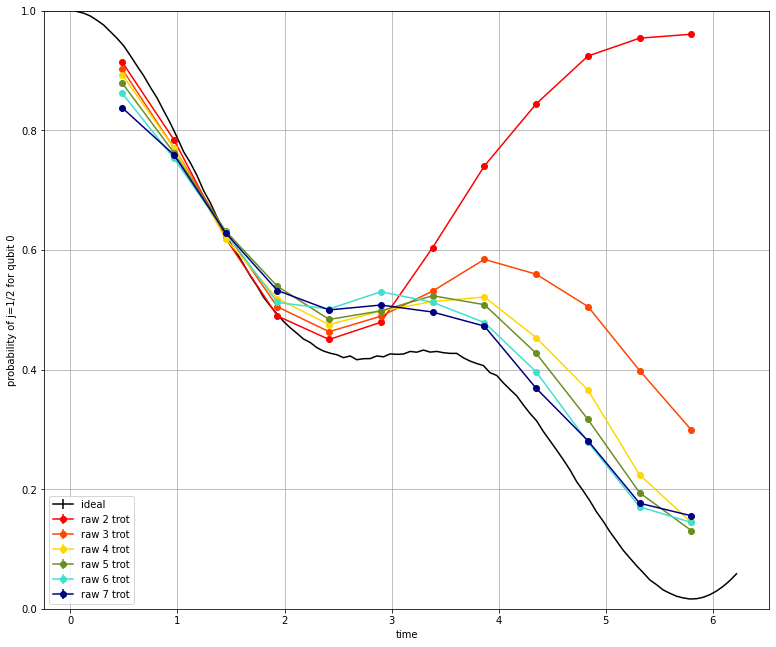

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['raw 2 trot','raw 3 trot','raw 4 trot','raw 5 trot','raw 6 trot','raw 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,P_id, db, linestyle='-', marker='', color='black',label='ideal')
for i in range (0,num_trots):
  plt.errorbar(times,Probs_raw[i], db, linestyle='-', marker='o', color=colors[i],label=labels[i])


plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

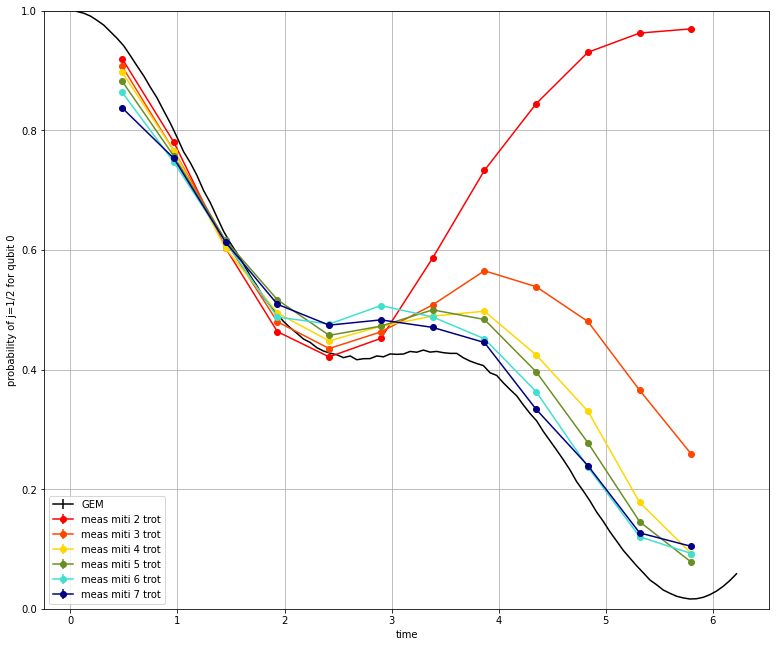

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['meas miti 2 trot','meas miti 3 trot','meas miti 4 trot','meas miti 5 trot','meas miti 6 trot','meas miti 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,P_id, db, linestyle='-', marker='', color='black',label='GEM')
for i in range (0,num_trots):
  plt.errorbar(times,Probs_meas[i], db, linestyle='-', marker='o', color=colors[i],label=labels[i])


plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

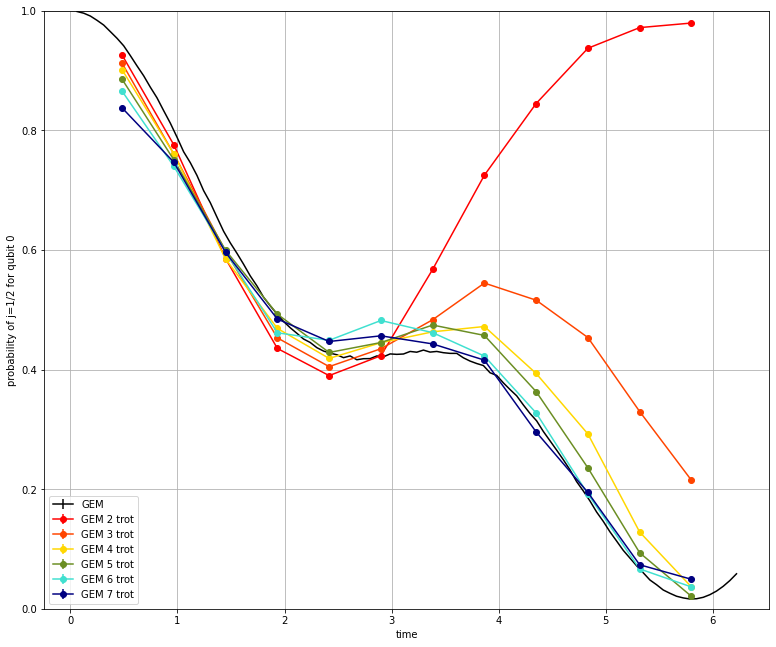

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['GEM 2 trot','GEM 3 trot','GEM 4 trot','GEM 5 trot','GEM 6 trot','GEM 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,P_id, db, linestyle='-', marker='', color='black',label='GEM')
for i in range (0,num_trots):
  plt.errorbar(times,Probs_GEM[i], db, linestyle='-', marker='o', color=colors[i],label=labels[i])


plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

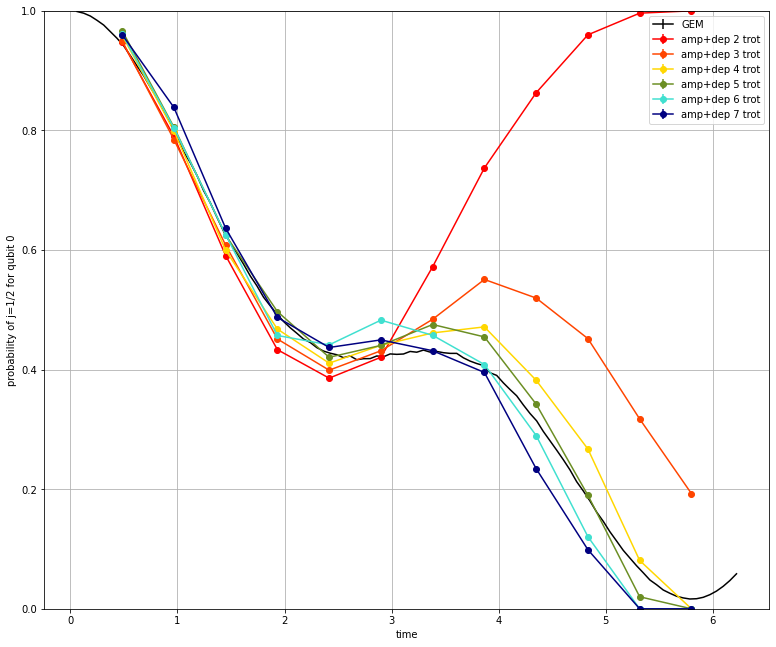

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['amp+dep 2 trot','amp+dep 3 trot','amp+dep 4 trot','amp+dep 5 trot','amp+dep 6 trot','amp+dep 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,P_id, db, linestyle='-', marker='', color='black',label='GEM')
for i in range (0,num_trots):
  plt.errorbar(times,Probs_GEM_P[i], db, linestyle='-', marker='o', color=colors[i],label=labels[i])


plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(P_t)

[0.04649406700114628, 0.07897711171097249, 0.12000215830877424, 0.16364799467658492, 0.1984807379289115, 0.2534649192377434]


In [ ]:
ideal_trots=[]
shots_ideal=100000
for j in range (0,num_trots):
  print(j)
  P_id=[]
  id_circ=[]
  for k in range (0,num_times):
    qr=QuantumRegister(2)
    cr=ClassicalRegister(1)
    qc=QuantumCircuit(qr,cr)
    qc.append(N_circ_OBC(j+2,times_id[k]),qr)
    qc.measure(qr[0],cr)
    id_circ.append(qc)
  job_ideal=execute(id_circ,backend_sim_ideal,shots=shots_ideal)
  job_res_id=job_ideal.result()
  counts_id=job_res_id.get_counts()
  for i in range (0,num_times):
    a=counts_id[i]
    for output in ['0']:
      if output in a:
          P_id.append(a[output]/shots_ideal)
      else:
          P_id.append(0)  
  print(P_id)
  ideal_trots.append(P_id)
print(P_id)

0
[0.99899, 0.99596, 0.99113, 0.98508, 0.97639, 0.96511, 0.95487, 0.9406, 0.92629, 0.90987, 0.89057, 0.87263, 0.85165, 0.8305, 0.80896, 0.78603, 0.7632, 0.7392, 0.71745, 0.69174, 0.67188, 0.64737, 0.62498, 0.60176, 0.5769, 0.55901, 0.53781, 0.51976, 0.50025, 0.48521, 0.47045, 0.45907, 0.44209, 0.4352, 0.42559, 0.4153, 0.41457, 0.4106, 0.40534, 0.40696, 0.40906, 0.41175, 0.41912, 0.42054, 0.43694, 0.44292, 0.45184, 0.46553, 0.4798, 0.49325, 0.51025, 0.52601, 0.54237, 0.56071, 0.57956, 0.59751, 0.61697, 0.63854, 0.65547, 0.67504, 0.69617, 0.71398, 0.73452, 0.75089, 0.77145, 0.79057, 0.8067, 0.82425, 0.84002, 0.8551, 0.87065, 0.88167, 0.89557, 0.90862, 0.91826, 0.92983, 0.93941, 0.94836, 0.95444, 0.96288, 0.96845, 0.97374, 0.97829, 0.98273, 0.98606, 0.98915, 0.99128, 0.99408, 0.99536, 0.99677, 0.99777, 0.99852, 0.9989, 0.99942, 0.99976, 0.99984, 0.99992, 0.99998, 1.0, 1.0]
1
[0.99909, 0.99614, 0.99067, 0.9845, 0.97607, 0.96567, 0.95467, 0.94202, 0.92637, 0.90882, 0.88981, 0.87283, 0.85194

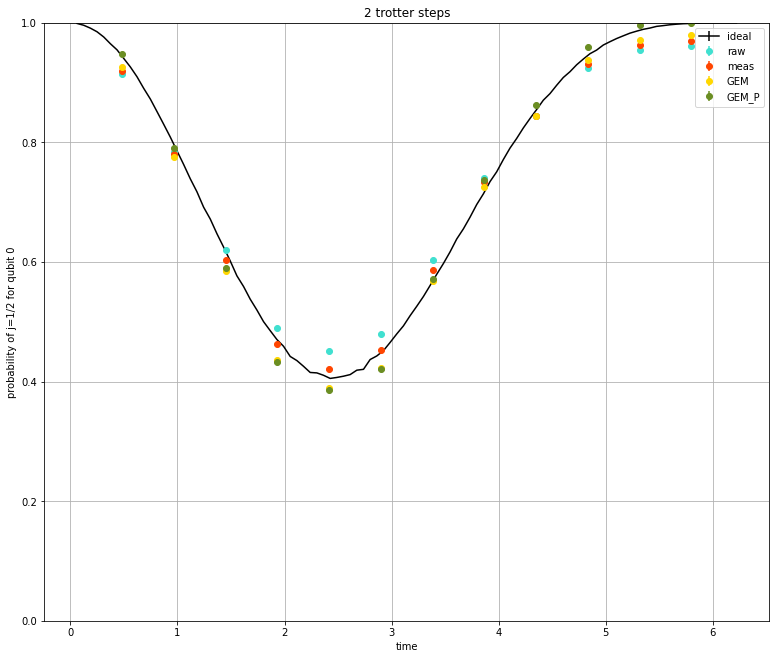

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['amp+dep 2 trot','amp+dep 3 trot','amp+dep 4 trot','amp+dep 5 trot','amp+dep 6 trot','amp+dep 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,ideal_trots[0], db, linestyle='-', marker='', color='black',label='ideal')
plt.errorbar(times,Probs_raw[0], db, linestyle='', marker='o', color=colors[4],label='raw')
plt.errorbar(times,Probs_meas[0], db, linestyle='', marker='o', color=colors[1],label='meas')
plt.errorbar(times,Probs_GEM[0], db, linestyle='', marker='o', color=colors[2],label='GEM')
plt.errorbar(times,Probs_GEM_P[0], db, linestyle='', marker='o', color=colors[3],label='GEM_P')

plt.title('2 trotter steps')
plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

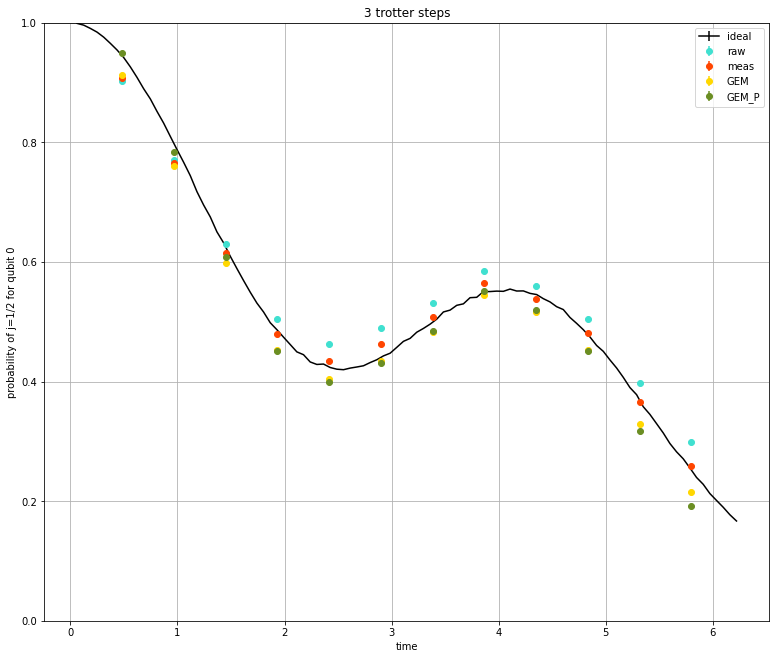

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['amp+dep 2 trot','amp+dep 3 trot','amp+dep 4 trot','amp+dep 5 trot','amp+dep 6 trot','amp+dep 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,ideal_trots[1], db, linestyle='-', marker='', color='black',label='ideal')
plt.errorbar(times,Probs_raw[1], db, linestyle='', marker='o', color=colors[4],label='raw')
plt.errorbar(times,Probs_meas[1], db, linestyle='', marker='o', color=colors[1],label='meas')
plt.errorbar(times,Probs_GEM[1], db, linestyle='', marker='o', color=colors[2],label='GEM')
plt.errorbar(times,Probs_GEM_P[1], db, linestyle='', marker='o', color=colors[3],label='GEM_P')

plt.title('3 trotter steps')
plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

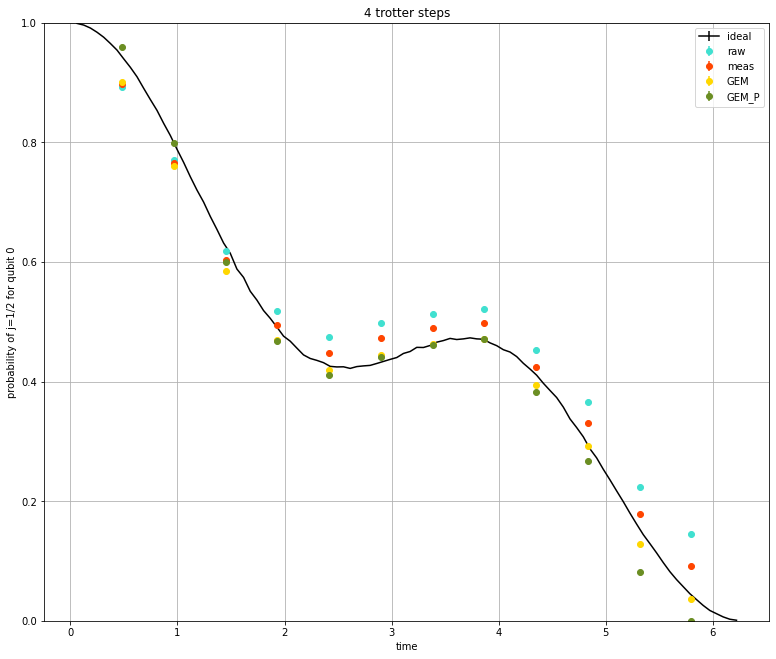

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['amp+dep 2 trot','amp+dep 3 trot','amp+dep 4 trot','amp+dep 5 trot','amp+dep 6 trot','amp+dep 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,ideal_trots[2], db, linestyle='-', marker='', color='black',label='ideal')
plt.errorbar(times,Probs_raw[2], db, linestyle='', marker='o', color=colors[4],label='raw')
plt.errorbar(times,Probs_meas[2], db, linestyle='', marker='o', color=colors[1],label='meas')
plt.errorbar(times,Probs_GEM[2], db, linestyle='', marker='o', color=colors[2],label='GEM')
plt.errorbar(times,Probs_GEM_P[2], db, linestyle='', marker='o', color=colors[3],label='GEM_P')

plt.title('4 trotter steps')
plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

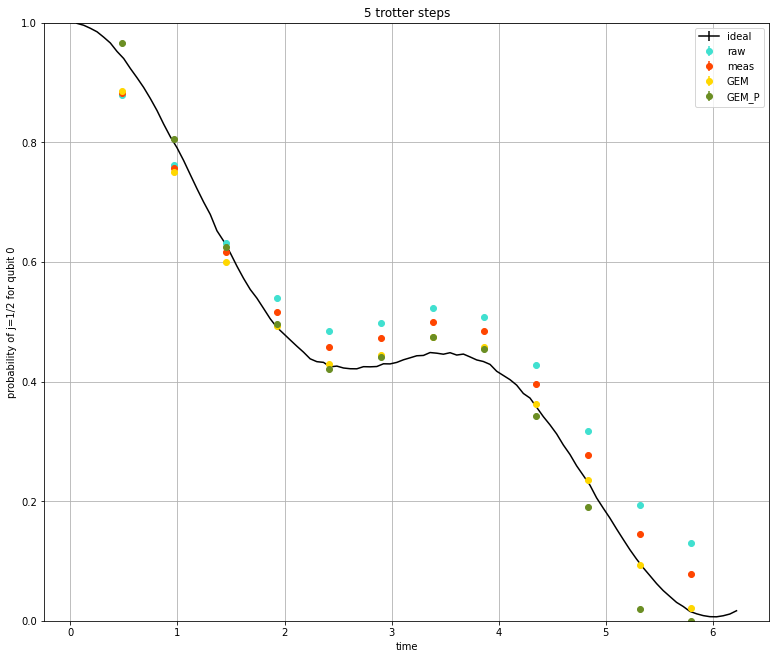

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['amp+dep 2 trot','amp+dep 3 trot','amp+dep 4 trot','amp+dep 5 trot','amp+dep 6 trot','amp+dep 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,ideal_trots[3], db, linestyle='-', marker='', color='black',label='ideal')
plt.errorbar(times,Probs_raw[3], db, linestyle='', marker='o', color=colors[4],label='raw')
plt.errorbar(times,Probs_meas[3], db, linestyle='', marker='o', color=colors[1],label='meas')
plt.errorbar(times,Probs_GEM[3], db, linestyle='', marker='o', color=colors[2],label='GEM')
plt.errorbar(times,Probs_GEM_P[3], db, linestyle='', marker='o', color=colors[3],label='GEM_P')

plt.title('5 trotter steps')
plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

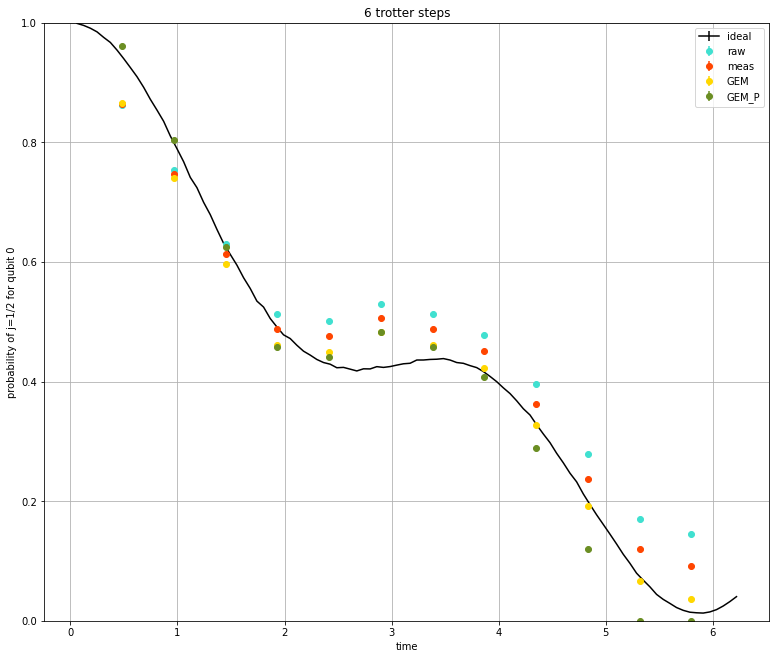

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['amp+dep 2 trot','amp+dep 3 trot','amp+dep 4 trot','amp+dep 5 trot','amp+dep 6 trot','amp+dep 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,ideal_trots[4], db, linestyle='-', marker='', color='black',label='ideal')
plt.errorbar(times,Probs_raw[4], db, linestyle='', marker='o', color=colors[4],label='raw')
plt.errorbar(times,Probs_meas[4], db, linestyle='', marker='o', color=colors[1],label='meas')
plt.errorbar(times,Probs_GEM[4], db, linestyle='', marker='o', color=colors[2],label='GEM')
plt.errorbar(times,Probs_GEM_P[4], db, linestyle='', marker='o', color=colors[3],label='GEM_P')

plt.title('6 trotter steps')
plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

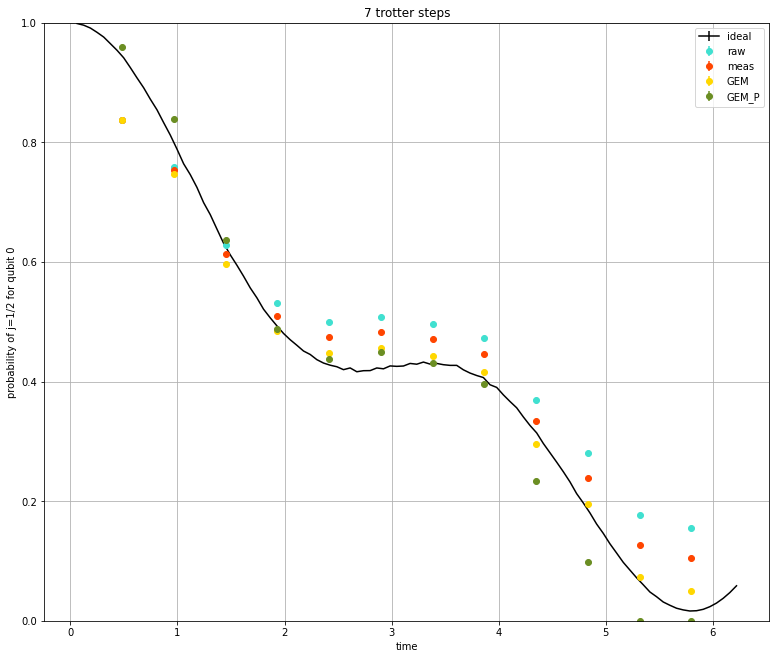

In [ ]:
db=0.000000001

colors=['red','orangered','gold','olivedrab','turquoise','navy']
labels=['amp+dep 2 trot','amp+dep 3 trot','amp+dep 4 trot','amp+dep 5 trot','amp+dep 6 trot','amp+dep 7 trot']
plt.figure(figsize=(13,11))
plt.errorbar(times_id,ideal_trots[5], db, linestyle='-', marker='', color='black',label='ideal')
plt.errorbar(times,Probs_raw[5], db, linestyle='', marker='o', color=colors[4],label='raw')
plt.errorbar(times,Probs_meas[5], db, linestyle='', marker='o', color=colors[1],label='meas')
plt.errorbar(times,Probs_GEM[5], db, linestyle='', marker='o', color=colors[2],label='GEM')
plt.errorbar(times,Probs_GEM_P[5], db, linestyle='', marker='o', color=colors[3],label='GEM_P')

plt.title('7 trotter steps')
plt.xlabel('time')
plt.ylabel(r'probability of j=1/2 for qubit 0')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()